# Exercício 03

**Instruções gerais:** Sua submissão <u>deve</u> conter:
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

## Redução de dimensionalidade

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm

import time

from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score, roc_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

plt.style.use('default')
sns.set_palette("pastel")

Usando o dispositivo: cuda


**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser achados em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [ ]:
# Importando o dataset:
data = pd.read_csv("./penguins.csv", header=None).to_numpy()
y = data[:,4]
x = data[:,0:4]

In [ ]:
def PCA(x, y, n_components):
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x_norm = (x - x_mean) / x_std
    cov_matrix = np.cov(x_norm.T)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # sort eigenvalues and eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # choose the k largest eigenvalues
    projection_matrix = eigenvectors[:,:n_components]

    # project
    x_projected = x_norm.dot(projection_matrix)

    # explained variance
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues[:n_components] / total_variance

    # concatenate the projected data with the labels
    data_projected = np.hstack((x_projected, y.reshape(-1,1)))

    return data_projected, explained_variance_ratio, eigenvalues

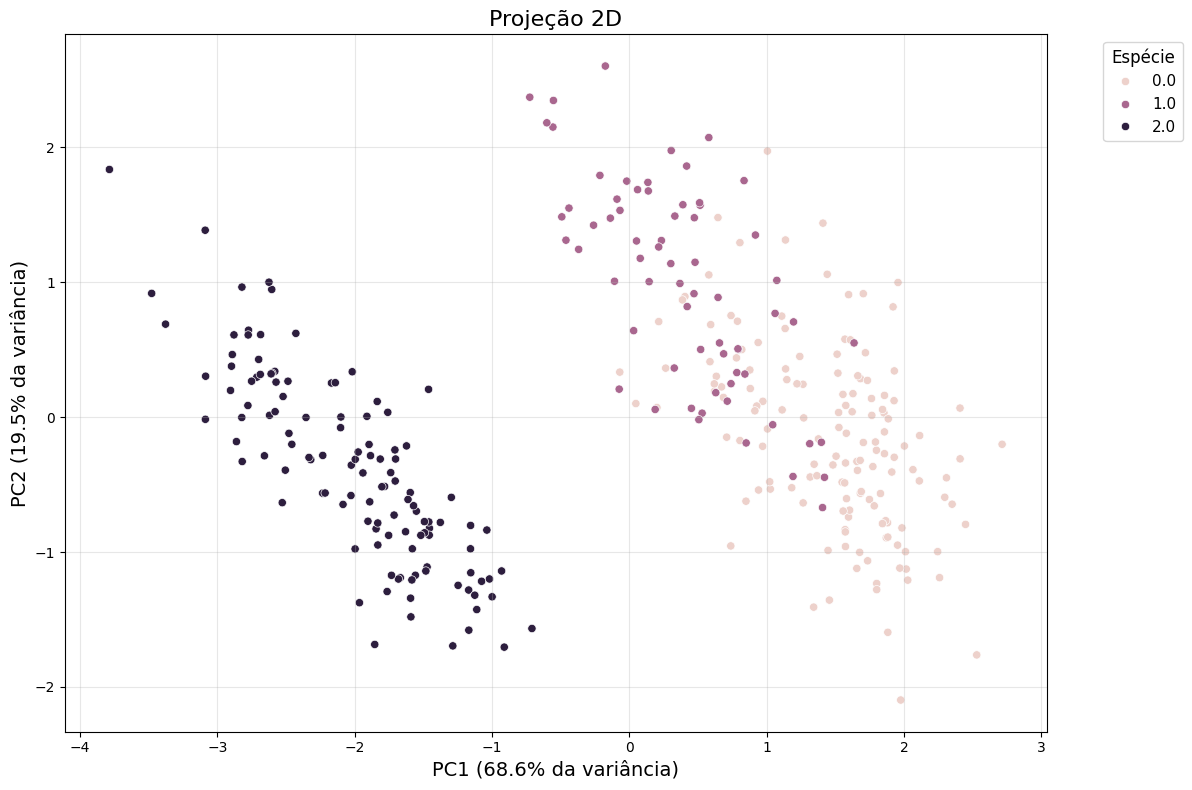

In [ ]:
projection,explained_var_2d, eigenvals= PCA(x, y, 2)

df_projection = pd.DataFrame(projection, columns=['PC1', 'PC2', 'Species'])

#display(df_projection.head(5))

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_projection, x='PC1', y='PC2', hue='Species')
plt.title('Projeção 2D', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_2d[0]:.1%} da variância)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_2d[1]:.1%} da variância)', fontsize=14)
plt.legend(title='Espécie', title_fontsize=12, fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

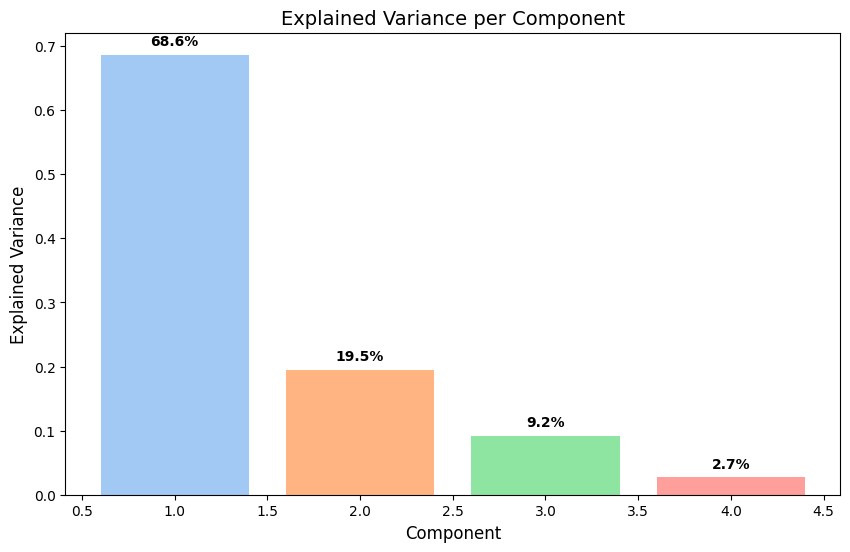

In [ ]:
n_components_list = [1, 2, 3, 4]
results = {}

# calculate explained variance
for n_comp in n_components_list:
    _, explained_var, eigenvals = PCA(x, y, n_comp)
    results[n_comp] = {
        'explained_variance_ratio': explained_var,
        'cumulative_variance': np.cumsum(explained_var),
        'total_variance': np.sum(explained_var)
    }


# plot
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()

explained_variance_ratio = results[4]['explained_variance_ratio']

bars = ax.bar(range(1, 5), explained_variance_ratio, color=sns.color_palette("pastel"))
ax.set_xlabel('Component', fontsize=12)
ax.set_ylabel('Explained Variance', fontsize=12)
ax.set_title('Explained Variance per Component', fontsize=14)

# values
for i, v in enumerate(explained_variance_ratio):
    ax.text(i+1, v+0.01, f'{v*100:.1f}%', ha='center', va='bottom', fontweight='bold')


### Corretude

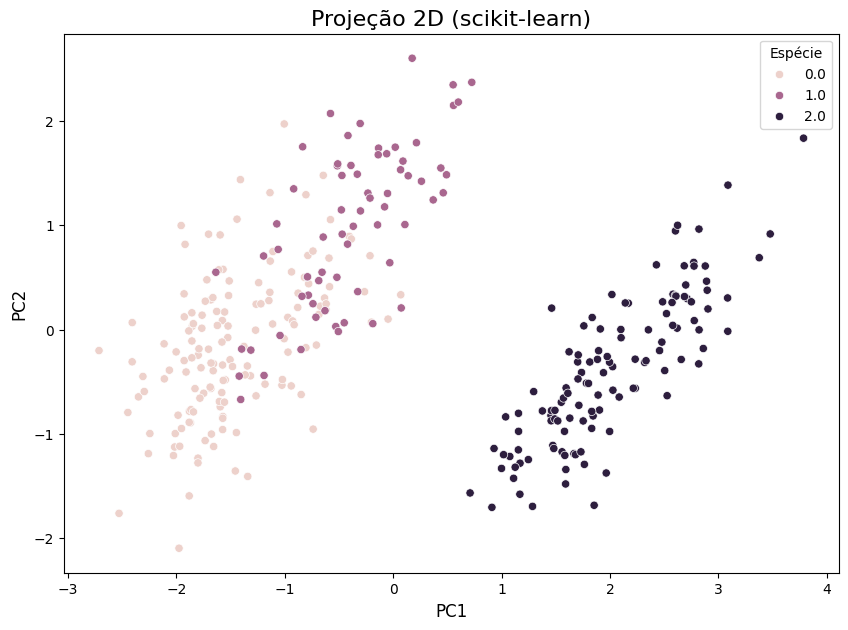

Variância explicada (nossa implementação): [0.68633893 0.19452929]
Variância explicada (scikit-learn): [0.68633893 0.19452929]


In [ ]:
from sklearn.decomposition import PCA


# PCA scikit-learn
x_normalized = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
pca_sk = PCA(n_components=2)
penguins_projected_sk = pca_sk.fit_transform(x_normalized)

# Organizar os dados projetados com numpy
data_projected = np.hstack((penguins_projected_sk, y.reshape(-1,1)))

# Plot da projeção 2D do scikit-learn
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_projected[:,0], y=data_projected[:,1], hue=data_projected[:,2])
plt.title('Projeção 2D (scikit-learn)', fontsize=16)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.legend(title='Espécie')
plt.show()

# Comparação da variância explicada
print("Variância explicada (nossa implementação):", explained_var_2d)
print("Variância explicada (scikit-learn):", pca_sk.explained_variance_ratio_)

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [ ]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.17MB/s]


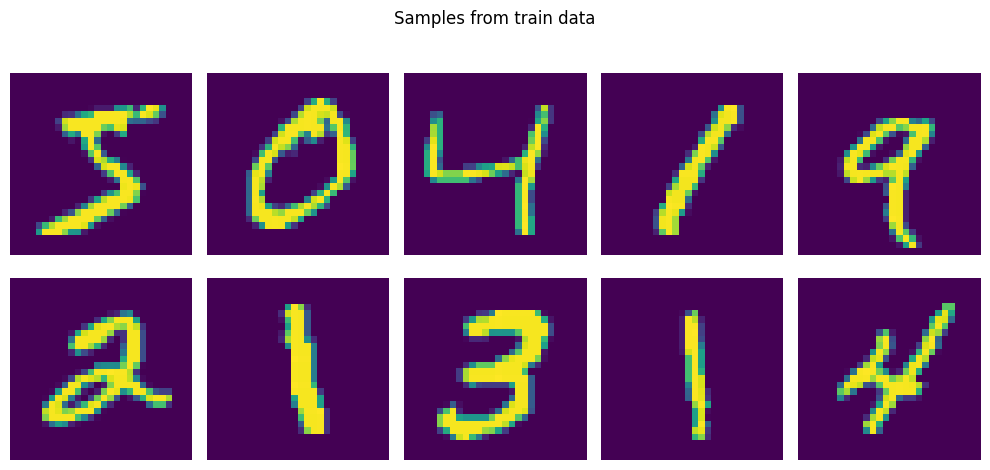

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')

fig.suptitle("Samples from train data")
fig.tight_layout()

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# decoder with a MLP for MNIST
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 28*28)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# use validation for early stopping
def validate(data_loader):
    total_loss = 0
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = encoder(x)
            decoded = decoder(encoded)
            l = loss(decoded, x.view(-1, 28*28))
            total_loss += l.item()
    return total_loss / len(data_loader)

# train the model with early stopping
epochs = 100
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    encoder.train()
    decoder.train()
    for batch in train_loader:
        optimizer.zero_grad()
        x, _ = batch
        x = x.to(device)
        encoded = encoder(x)
        decoded = decoder(encoded)
        l = loss(decoded, x.view(-1, 28*28))
        l.backward()
        optimizer.step()

    val_loss = validate(val_loader)

    print(f'Epoch: {epoch+1}, Train Loss: {l.item():.4f}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0

    else:
        epochs_no_improve += 1
        if epochs_no_improve == 2:
            print(f'Early stopping triggered after {epoch+1} epochs due to no improvement.')
            break


Epoch: 1, Train Loss: 0.0517, Validation Loss: 0.0515
Epoch: 2, Train Loss: 0.0468, Validation Loss: 0.0465
Epoch: 3, Train Loss: 0.0469, Validation Loss: 0.0440
Epoch: 4, Train Loss: 0.0426, Validation Loss: 0.0428
Epoch: 5, Train Loss: 0.0416, Validation Loss: 0.0422
Epoch: 6, Train Loss: 0.0430, Validation Loss: 0.0412
Epoch: 7, Train Loss: 0.0383, Validation Loss: 0.0410
Epoch: 8, Train Loss: 0.0404, Validation Loss: 0.0404
Epoch: 9, Train Loss: 0.0391, Validation Loss: 0.0397
Epoch: 10, Train Loss: 0.0447, Validation Loss: 0.0396
Epoch: 11, Train Loss: 0.0374, Validation Loss: 0.0396
Epoch: 12, Train Loss: 0.0404, Validation Loss: 0.0393
Epoch: 13, Train Loss: 0.0344, Validation Loss: 0.0388
Epoch: 14, Train Loss: 0.0388, Validation Loss: 0.0387
Epoch: 15, Train Loss: 0.0349, Validation Loss: 0.0386
Epoch: 16, Train Loss: 0.0341, Validation Loss: 0.0382
Epoch: 17, Train Loss: 0.0392, Validation Loss: 0.0380
Epoch: 18, Train Loss: 0.0361, Validation Loss: 0.0380
Epoch: 19, Train Lo

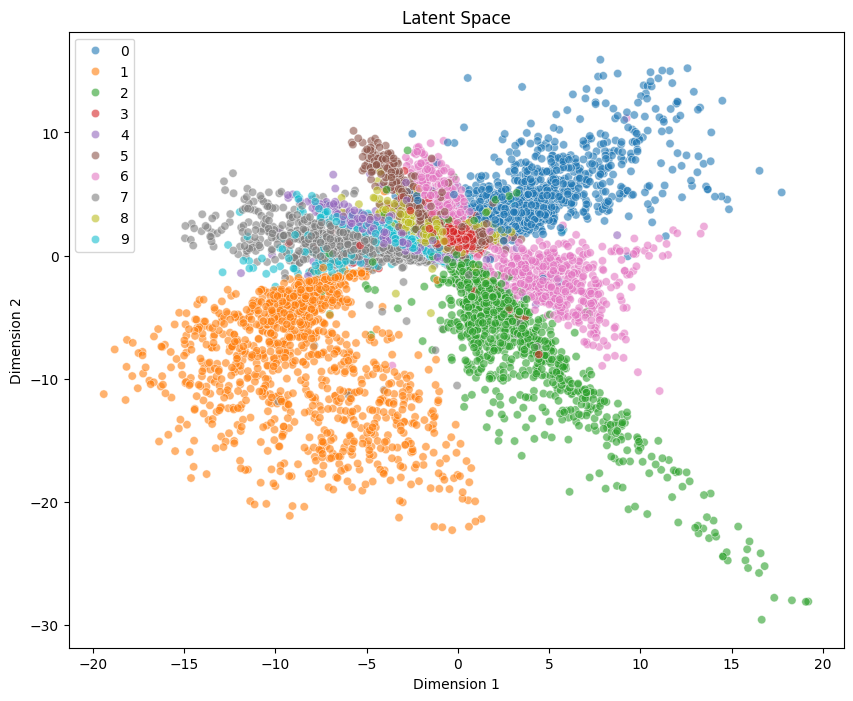

In [ ]:
encoder.eval()
decoder.eval()

latent_representations = []
test_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        encoded = encoder(x)
        latent_representations.append(encoded.cpu().numpy())
        test_labels.append(y.cpu().numpy())

latent_representations = np.concatenate(latent_representations, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=latent_representations[:, 0], y=latent_representations[:, 1], hue=test_labels, palette=sns.color_palette("tab10", 10), legend='full', alpha=0.6)
plt.title('Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Comentário

Podemos concluir que, no geral, as imagens com o mesmo rótulo foram, de fato, agrupadas na projeção bidimensional, indicando que a projeção das imagens de teste no espaço latente foi realizada corretamente.

Contudo, há de se notar que há vários pontos de dados "perdidos", que estão misturados com a classe incorreta. Principalmente, por exemplo, o 9 e o 4, que possuem clusters muito misturados, dificultando a separação.

## K-means e Mixture models

## Exercícios práticos

In [ ]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,
                                                           transform=torchvision.transforms.ToTensor())

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                            transform=torchvision.transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


In [ ]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
        if i >= 8: break
    plt.suptitle(dataset.__class__.__name__)
    plt.tight_layout()

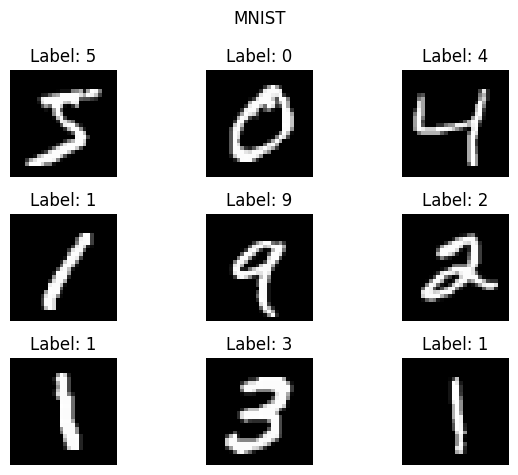

In [ ]:
display_nine_images(mnist_trainset)

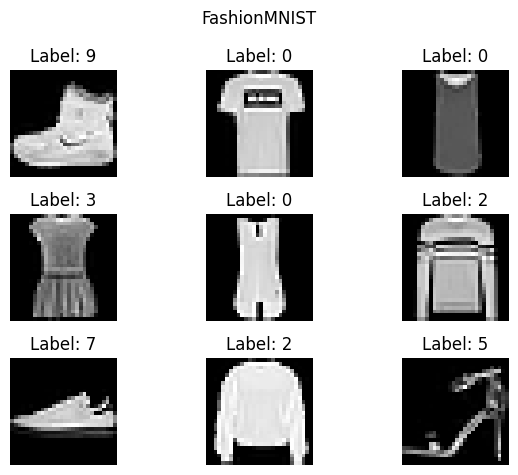

In [ ]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [ ]:
def preparar_dados_para_kmeans(dataset, max_samples=None):
    data_list = []
    labels_list = []

    num_samples = len(dataset) if max_samples is None else min(max_samples, len(dataset))

    for i in range(num_samples):
        image, label = dataset[i]
        image_flat = image.numpy().flatten()
        data_list.append(image_flat)
        labels_list.append(label)

    data = np.array(data_list)
    labels = np.array(labels_list)

    return data, labels

In [ ]:
def inicializacao_aleatoria(data, k):
    m, n = data.shape
    centroids = np.empty((k, n))
    for i in range(k):
        centroids[i] = data[random.randint(0, m - 1)]
    return centroids

def inicializacao_kmeans_plus_plus(data, k):
    m, n = data.shape
    centroids = np.empty((k, n))
    centroids[0] = data[random.randint(0, m - 1)]

    for i in range(1, k):
        dists = np.array([min([np.linalg.norm(x - c)**2 for c in centroids[:i]]) for x in data])
        probs = dists / dists.sum()
        cumulative_probs = probs.cumsum()
        r = random.random()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids[i] = data[j]
                break
    return centroids

def inicializacao_media_classes(data, labels, k):
    _, n = data.shape
    centroids = np.empty((k, n))
    for i in range(k):
        class_data = data[labels == i]
        if len(class_data) > 0:
            centroids[i] = class_data.mean(axis=0)
        else:
            centroids[i] = data[random.randint(0, len(data) - 1)]
    return centroids

In [ ]:
def executar_kmeans(data, centroids, max_iter=100, tol=1e-4):
    k = centroids.shape[0]
    closest_centroids = None

    for iteration in range(max_iter):
        dists = np.array([np.linalg.norm(data - c, axis=1) for c in centroids])
        new_closest_centroids = np.argmin(dists, axis=0)

        if np.array_equal(closest_centroids, new_closest_centroids):
            print(f"Convergiu após {iteration} iterações")
            break

        closest_centroids = new_closest_centroids

        new_centroids = np.empty_like(centroids)
        for i in range(k):
            cluster_points = data[closest_centroids == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                new_centroids[i] = centroids[i]

        if np.allclose(centroids, new_centroids, atol=tol):
            print(f"Convergiu após {iteration} iterações (tolerância)")
            break

        centroids = new_centroids

    return centroids, closest_centroids

def mapear_clusters_para_rotulos(closest_centroids, true_labels, k):
    cluster_labels = {}
    for i in range(k):
        labels_in_cluster = true_labels[closest_centroids == i]
        if len(labels_in_cluster) > 0:
            cluster_labels[i] = np.bincount(labels_in_cluster).argmax()
        else:
            cluster_labels[i] = -1

    mapped_labels = np.array([cluster_labels.get(c, -1) for c in closest_centroids])
    return mapped_labels

def calcular_metricas(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    # ari = adjusted_rand_score(true_labels, predicted_labels)
    # nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    return {'accuracy': accuracy}

In [ ]:
def plotar_matriz_confusao(true_labels, predicted_labels, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Rótulo Predito')
    plt.ylabel('Rótulo Real')
    plt.title(title)
    plt.show()

def plotar_exemplos_clusters(data, mapped_labels, k, title="Exemplos dos Clusters"):
    fig, ax = plt.subplots(k, 10, figsize=(12, k*1.2))
    fig.suptitle(title, fontsize=16)

    images = data.reshape(data.shape[0], 28, 28)

    for i in range(k):
        cluster_indices = np.where(mapped_labels == i)[0]

        if len(cluster_indices) > 0:
            sample_indices = np.random.choice(cluster_indices,
                                            size=min(10, len(cluster_indices)),
                                            replace=False)

            for j, sample_idx in enumerate(sample_indices):
                ax[i, j].imshow(images[sample_idx], cmap='gray')
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                if j == 0:
                    ax[i, j].set_ylabel(f'Cluster {i}', rotation=90, va='center')
        else:
            for j in range(10):
                ax[i, j].axis('off')
                if j == 0:
                    ax[i, j].text(0.5, 0.5, f'Cluster {i}\n(Vazio)',
                                ha='center', va='center', transform=ax[i, j].transAxes)

    plt.tight_layout()
    plt.show()

In [ ]:
train_data, train_labels = preparar_dados_para_kmeans(mnist_trainset, max_samples=10000)
print(f"Dados preparados: {train_data.shape[0]} amostras, {train_data.shape[1]} features")

K = 10

Dados preparados: 10000 amostras, 784 features


INICIALIZAÇÃO ALEATÓRIA
Convergiu após 53 iterações
Métricas - Inicialização Aleatória:
  Accuracy: 0.5836


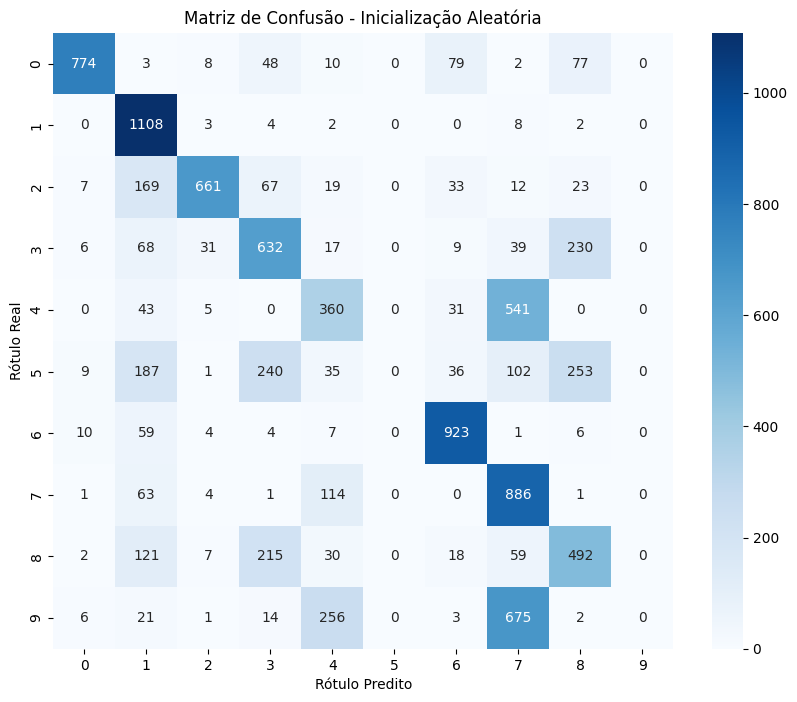

In [ ]:
print("INICIALIZAÇÃO ALEATÓRIA")

centroids_aleatorios = inicializacao_aleatoria(train_data, K)

centroids_finais_aleatorio, clusters_aleatorio = executar_kmeans(train_data, centroids_aleatorios)

mapped_labels_aleatorio = mapear_clusters_para_rotulos(clusters_aleatorio, train_labels, K)

metricas_aleatorio = calcular_metricas(train_labels, mapped_labels_aleatorio)
print(f"Métricas - Inicialização Aleatória:")
print(f"  Accuracy: {metricas_aleatorio['accuracy']:.4f}")

plotar_matriz_confusao(train_labels, mapped_labels_aleatorio,
                      'Matriz de Confusão - Inicialização Aleatória')

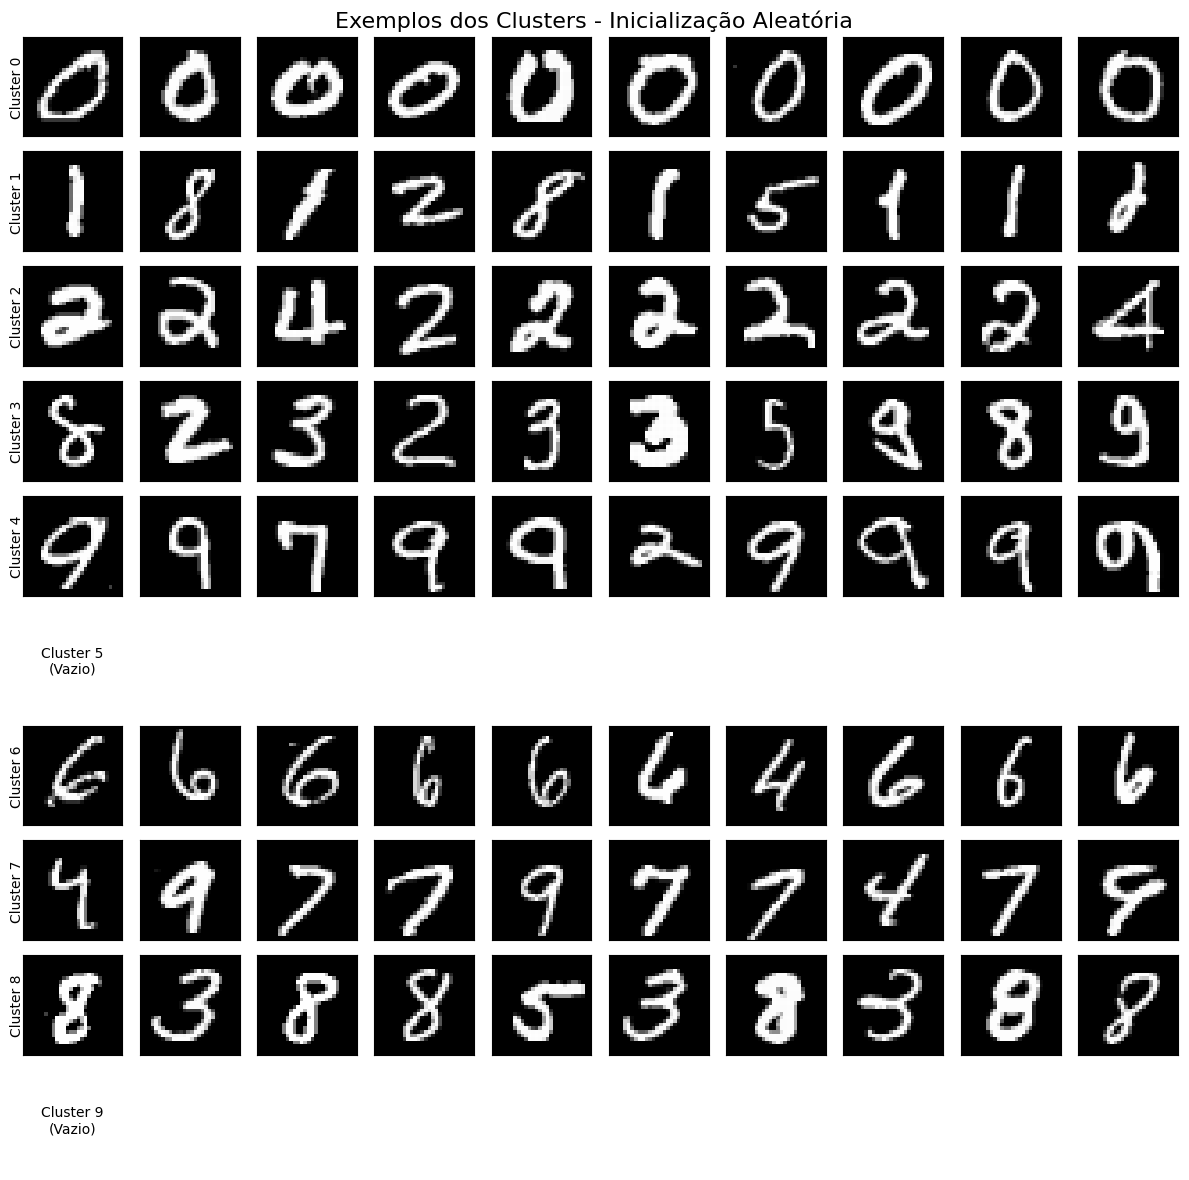

In [ ]:
plotar_exemplos_clusters(train_data, mapped_labels_aleatorio, K,
                        'Exemplos dos Clusters - Inicialização Aleatória')

INICIALIZAÇÃO K-MEANS++
Convergiu após 40 iterações
Métricas - K-Means++:
  Accuracy: 0.5801


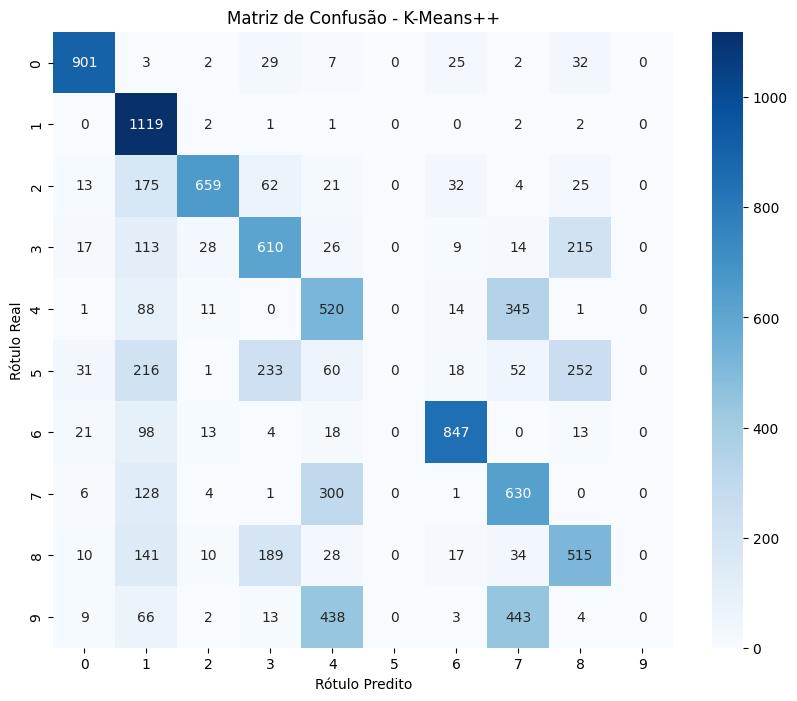

In [ ]:
print("INICIALIZAÇÃO K-MEANS++")

centroids_kpp = inicializacao_kmeans_plus_plus(train_data, K)

centroids_finais_kpp, clusters_kpp = executar_kmeans(train_data, centroids_kpp)

mapped_labels_kpp = mapear_clusters_para_rotulos(clusters_kpp, train_labels, K)

metricas_kpp = calcular_metricas(train_labels, mapped_labels_kpp)
print(f"Métricas - K-Means++:")
print(f"  Accuracy: {metricas_kpp['accuracy']:.4f}")

plotar_matriz_confusao(train_labels, mapped_labels_kpp,
                      'Matriz de Confusão - K-Means++')

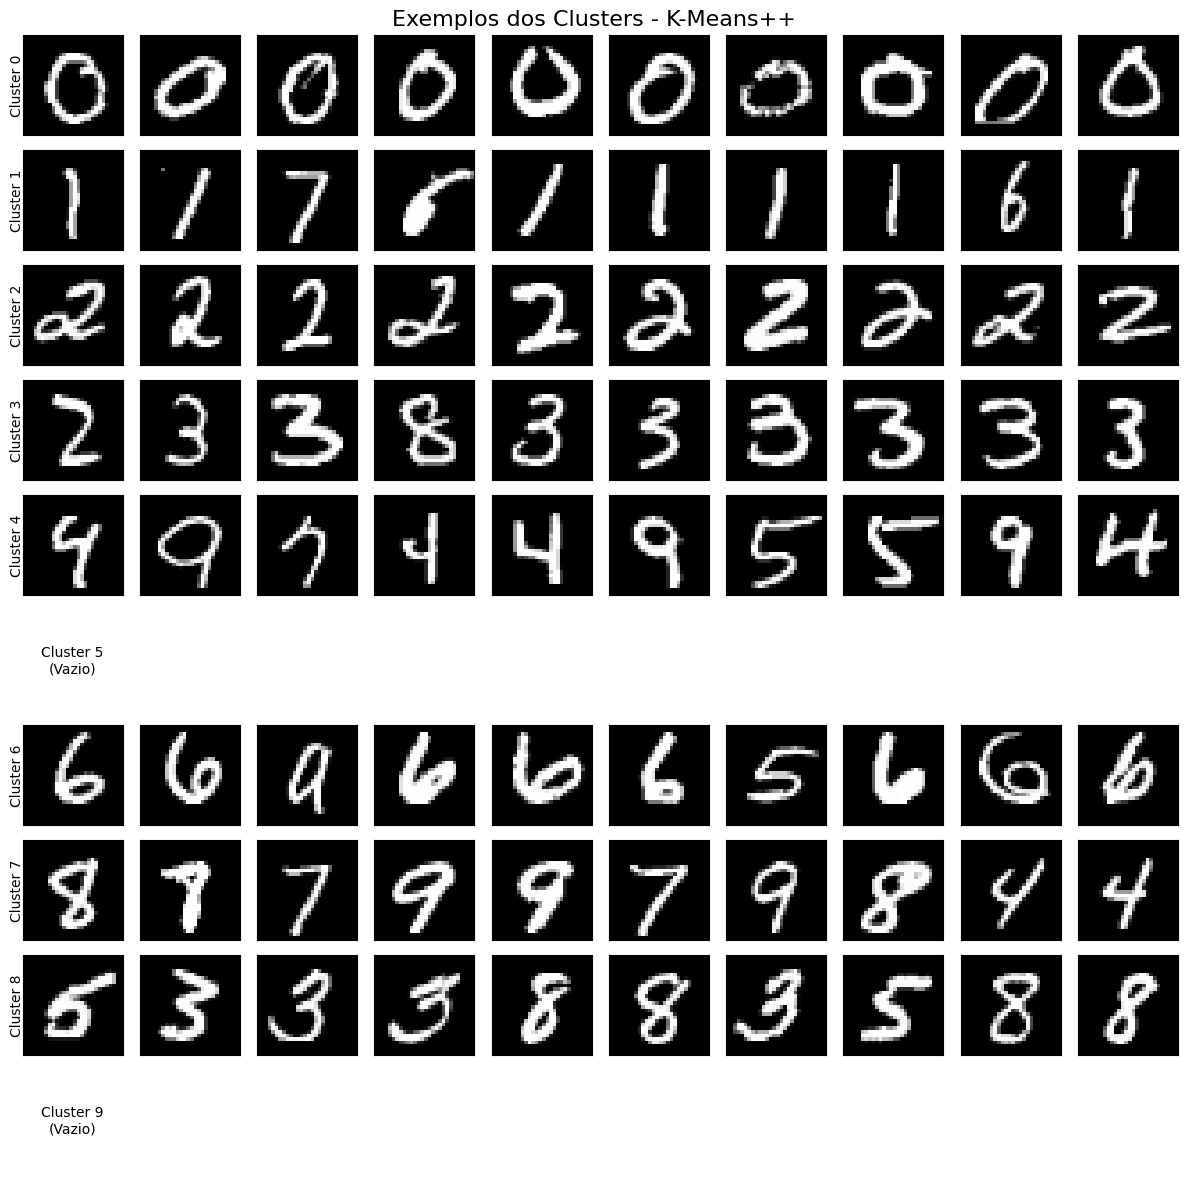

In [ ]:
plotar_exemplos_clusters(train_data, mapped_labels_kpp, K,
                        'Exemplos dos Clusters - K-Means++')

INICIALIZAÇÃO MÉDIA DAS CLASSES
Centroides inicializados com média das classes
Convergiu após 86 iterações
Métricas - Inicialização Média das Classes:
  Accuracy: 0.6271


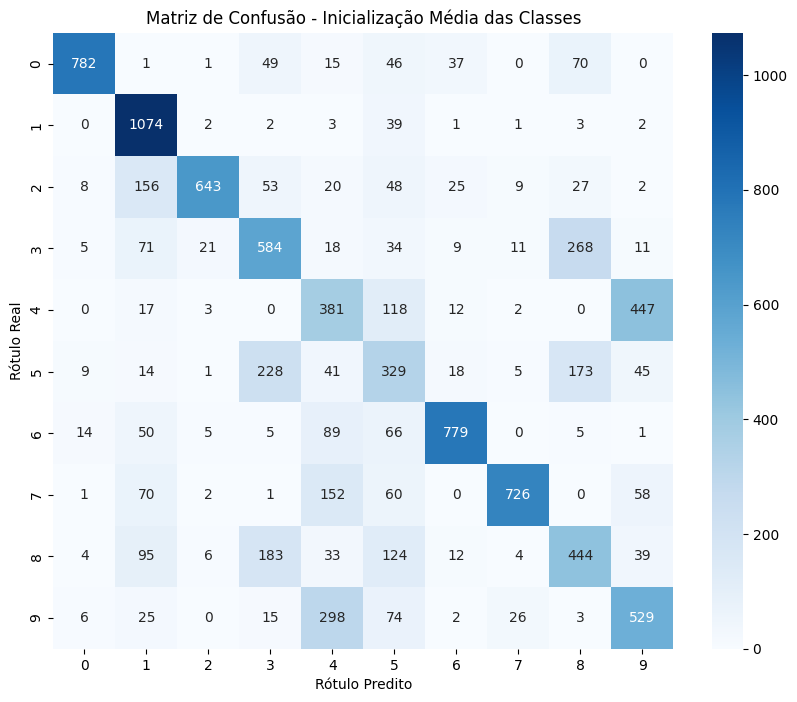

In [ ]:
print("INICIALIZAÇÃO MÉDIA DAS CLASSES")

centroids_media = inicializacao_media_classes(train_data, train_labels, K)
print("Centroides inicializados com média das classes")

centroids_finais_media, clusters_media = executar_kmeans(train_data, centroids_media)

mapped_labels_media = mapear_clusters_para_rotulos(clusters_media, train_labels, K)

metricas_media = calcular_metricas(train_labels, mapped_labels_media)
print(f"Métricas - Inicialização Média das Classes:")
print(f"  Accuracy: {metricas_media['accuracy']:.4f}")

plotar_matriz_confusao(train_labels, mapped_labels_media,
                      'Matriz de Confusão - Inicialização Média das Classes')

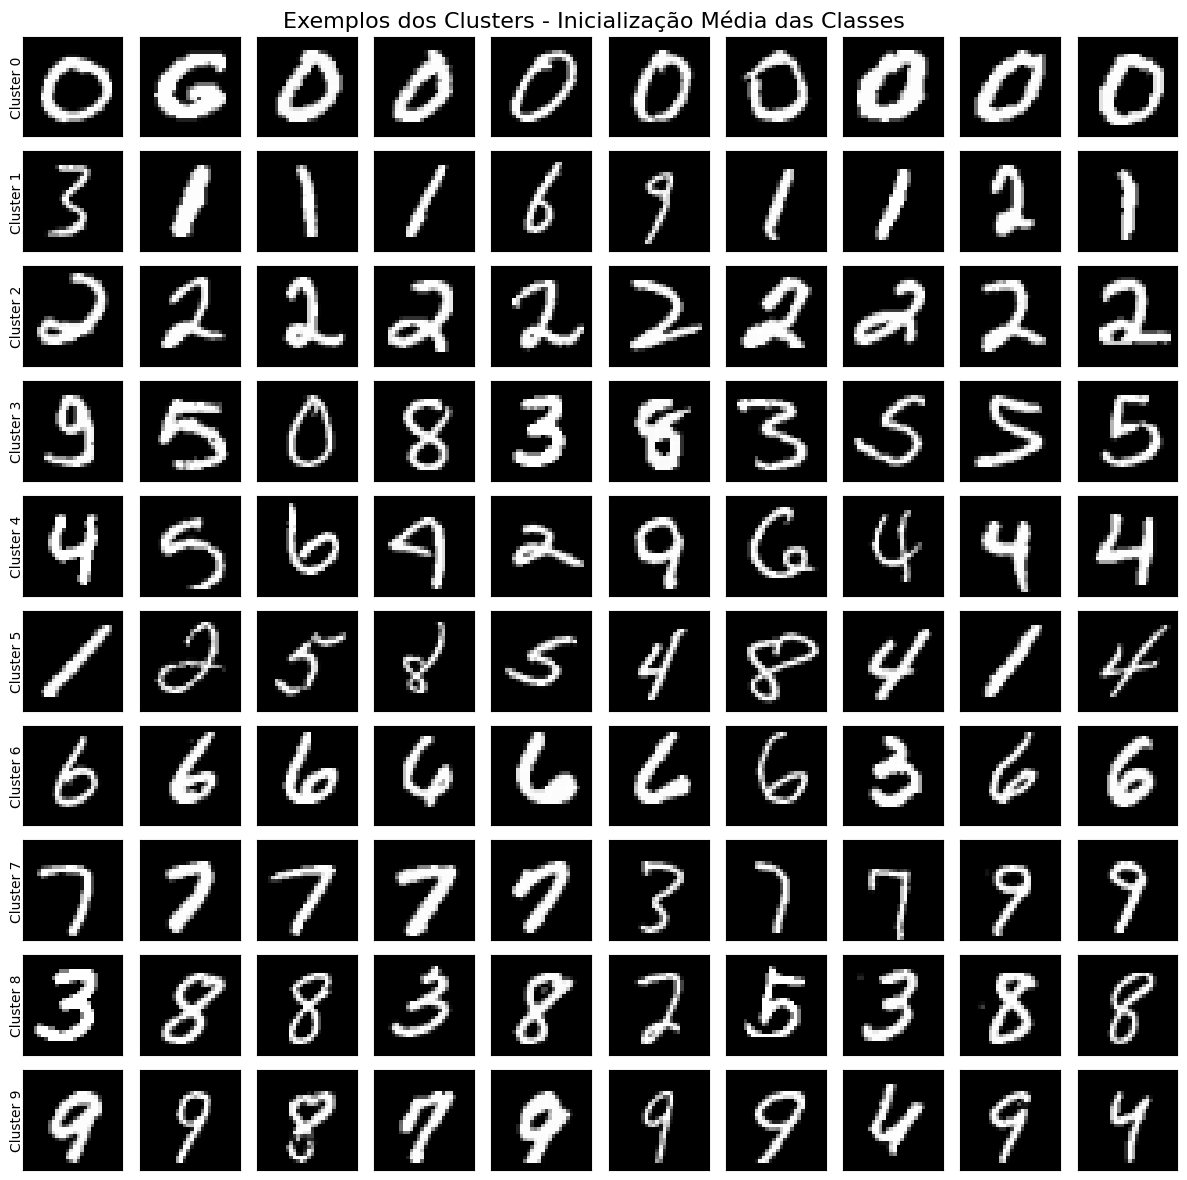

In [ ]:
plotar_exemplos_clusters(train_data, mapped_labels_media, K,
                        'Exemplos dos Clusters - Inicialização Média das Classes')


Tabela Comparativa de Resultados:
                    Método  Accuracy
0  Inicialização Aleatória    0.5836
1                K-Means++    0.5801
2        Média das Classes    0.6271


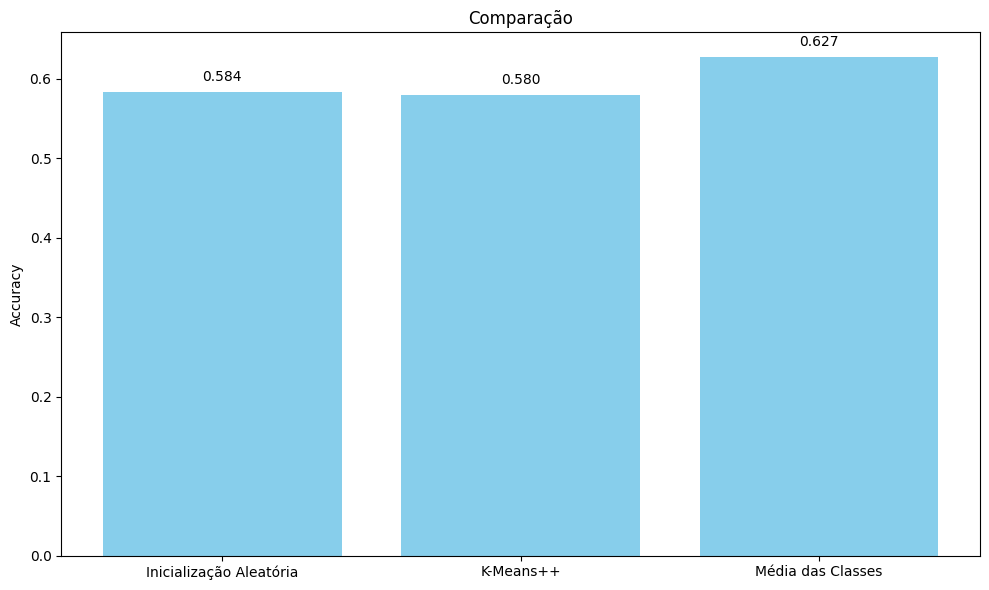

In [ ]:
resultados = pd.DataFrame({
    'Método': ['Inicialização Aleatória', 'K-Means++', 'Média das Classes'],
    'Accuracy': [metricas_aleatorio['accuracy'], metricas_kpp['accuracy'], metricas_media['accuracy']]
})

print("\nTabela Comparativa de Resultados:")
print(resultados.round(4))

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['skyblue']

ax.bar(resultados['Método'], resultados['Accuracy'], color=colors[0])
ax.set_title('Comparação')
ax.set_ylabel('Accuracy')
ax.tick_params(axis='x')

for j, v in enumerate(resultados['Accuracy']):
    ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Comentário

Em geral, as amostrar similares são agrupadas juntas. Contudo, o modelo está bem longe de ser ideal.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente:
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação.

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256], num_classes=10):
        super(MLP, self).__init__()
        layers = []

        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

    def get_penultimate_features(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers[:-1]:
            x = layer(x)
        return x

def train_mlp(model, train_loader, val_loader, epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print(f'Época {epoch}: Accuracy = {100 * correct / total:.2f}%')

In [ ]:
print("TREINANDO MLP PARA CLASSIFICAÇÃO DO MNIST")

mnist_train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(mnist_testset, batch_size=128, shuffle=False)
fashion_test_loader = DataLoader(fashion_mnist_trainset, batch_size=128, shuffle=False)

mlp_model = MLP()
train_mlp(mlp_model, mnist_train_loader, mnist_test_loader)

TREINANDO MLP PARA CLASSIFICAÇÃO DO MNIST
Época 0: Accuracy = 96.17%
Época 5: Accuracy = 98.17%
Época 10: Accuracy = 98.31%


In [ ]:
def extract_features(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            features_batch = model.get_penultimate_features(images)
            features.append(features_batch.cpu().numpy())

    return np.vstack(features)

train_features = extract_features(mlp_model, mnist_train_loader)
mnist_test_features = extract_features(mlp_model, mnist_test_loader)
fashion_test_features = extract_features(mlp_model, fashion_test_loader)

print(f"Features de treino: {train_features.shape}")
print(f"Features teste MNIST: {mnist_test_features.shape}")
print(f"Features teste FashionMNIST: {fashion_test_features.shape}")

Features de treino: (60000, 256)
Features teste MNIST: (10000, 256)
Features teste FashionMNIST: (60000, 256)


In [ ]:
n_components_list = [5, 10, 20, 30, 50]
results = []

for n_components in n_components_list:
    print(f"\nTreinando GMM com {n_components} componentes...")

    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(train_features)

    mnist_scores = gmm.score_samples(mnist_test_features)
    fashion_scores = gmm.score_samples(fashion_test_features)

    y_true = np.concatenate([np.ones(len(mnist_scores)), np.zeros(len(fashion_scores))])
    y_scores = np.concatenate([mnist_scores, fashion_scores])

    auc = roc_auc_score(y_true, y_scores)

    results.append({
        'n_components': n_components,
        'auc': auc,
        'mnist_scores': mnist_scores,
        'fashion_scores': fashion_scores
    })

    print(f"  AUC-ROC: {auc:.4f}")

best_result = max(results, key=lambda x: x['auc'])
print(f"\nMelhor configuração: {best_result['n_components']} componentes")
print(f"Melhor AUC-ROC: {best_result['auc']:.4f}")


Treinando GMM com 5 componentes...
  AUC-ROC: 0.9036

Treinando GMM com 10 componentes...
  AUC-ROC: 0.9027

Treinando GMM com 20 componentes...
  AUC-ROC: 0.9469

Treinando GMM com 30 componentes...
  AUC-ROC: 0.9573

Treinando GMM com 50 componentes...
  AUC-ROC: 0.9546

Melhor configuração: 30 componentes
Melhor AUC-ROC: 0.9573


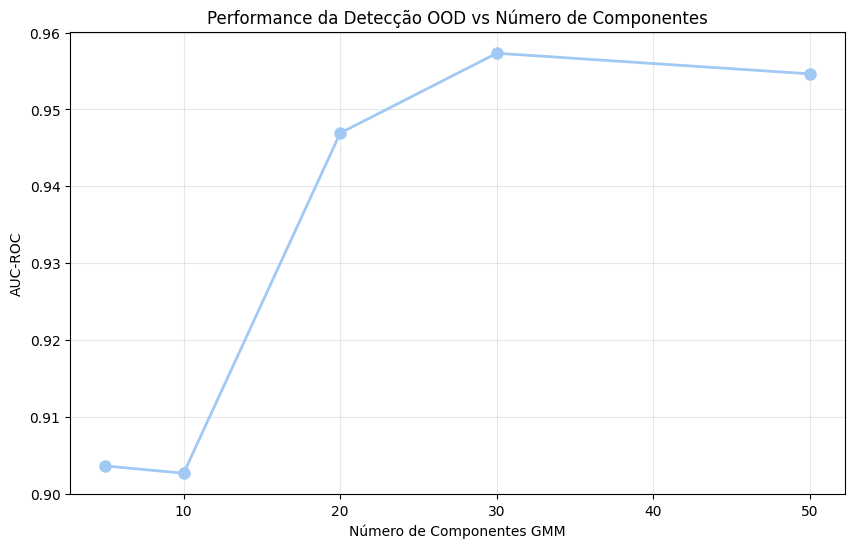

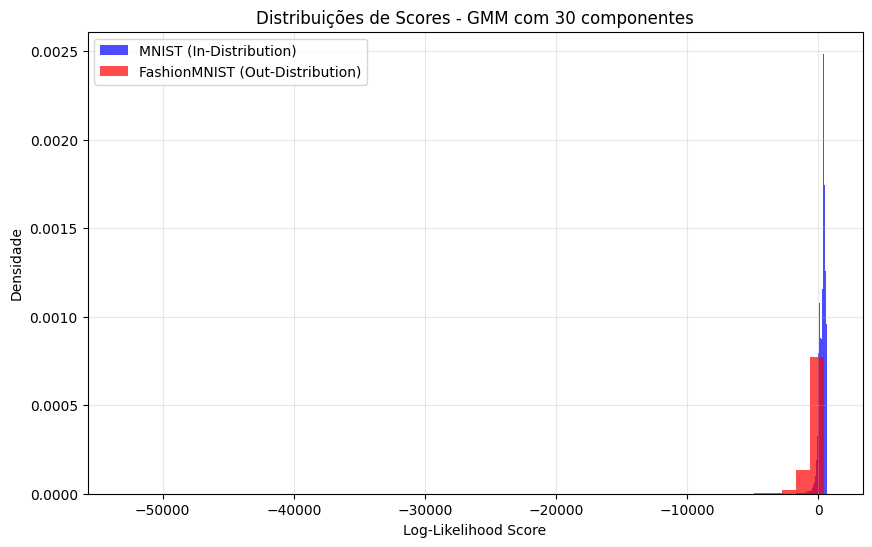

In [ ]:
aucs = [r['auc'] for r in results]
n_comps = [r['n_components'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(n_comps, aucs, 'o-', linewidth=2, markersize=8)
plt.xlabel('Número de Componentes GMM')
plt.ylabel('AUC-ROC')
plt.title('Performance da Detecção OOD vs Número de Componentes')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(best_result['mnist_scores'], bins=50, alpha=0.7, label='MNIST (In-Distribution)',
         density=True, color='blue')
plt.hist(best_result['fashion_scores'], bins=50, alpha=0.7, label='FashionMNIST (Out-Distribution)',
         density=True, color='red')
plt.xlabel('Log-Likelihood Score')
plt.ylabel('Densidade')
plt.title(f'Distribuições de Scores - GMM com {best_result["n_components"]} componentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [1]:
!pip install torch-sgld

## Modelos baseados em energia (EBM)

(-7.0, 7.0)

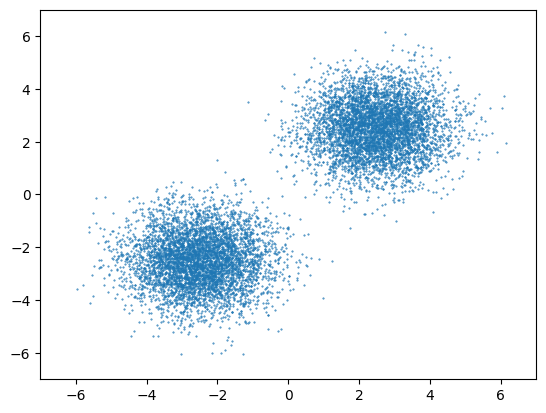

In [2]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch_sgld

N = 10000
d = 2
data = torch.randn((int(N/2),d)) + 2.5
data2 = torch.randn((int(N/2),d)) - 2.5
data = torch.cat((data, data2), dim=0)


plt.scatter(data[:,0], data[:,1], s=0.2)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

**1.** Considere as a amostras da distribuição acima, contidas na variável 'data'. Complete o código abaixo para implementar um modelo baseado em energia (EBM) que amostre aproximadamente da distribuição subjacente a esses dados. Depois de treinar o modelo, amostre do EBM e compare o resultado contra o scatterplot acima. Analise o efeito de mudar a quantidade de iterações de SGLD por época. Além disso, a implementação abaixo usa cadeias 'persistentes' entre épocas --- i.e., o estado final da última época é o inicial da atual. Qual o efeito de inicializar aleatoriamente a cadeia em cada iteração? E de inicializá-las nos pontos observados em 'data'?

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

h = 10
d = 2
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
data = data.to('cuda')

max_iter = 1000


x = torch.randn((N,2), device='cuda')*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.01)
sampler = torch_sgld.SGLD([x], lr=0.01)

chain_length=10

for i in range(max_iter):
    for i in range(chain_length):
        sampler.zero_grad()
        potential = E(x)
        potential.sum().backward()
        sampler.step()
    optimizer.zero_grad()
    loss = E(data).mean() - E(x.detach()).mean()
    loss.backward()
    optimizer.step()


Usando dispositivo: cuda


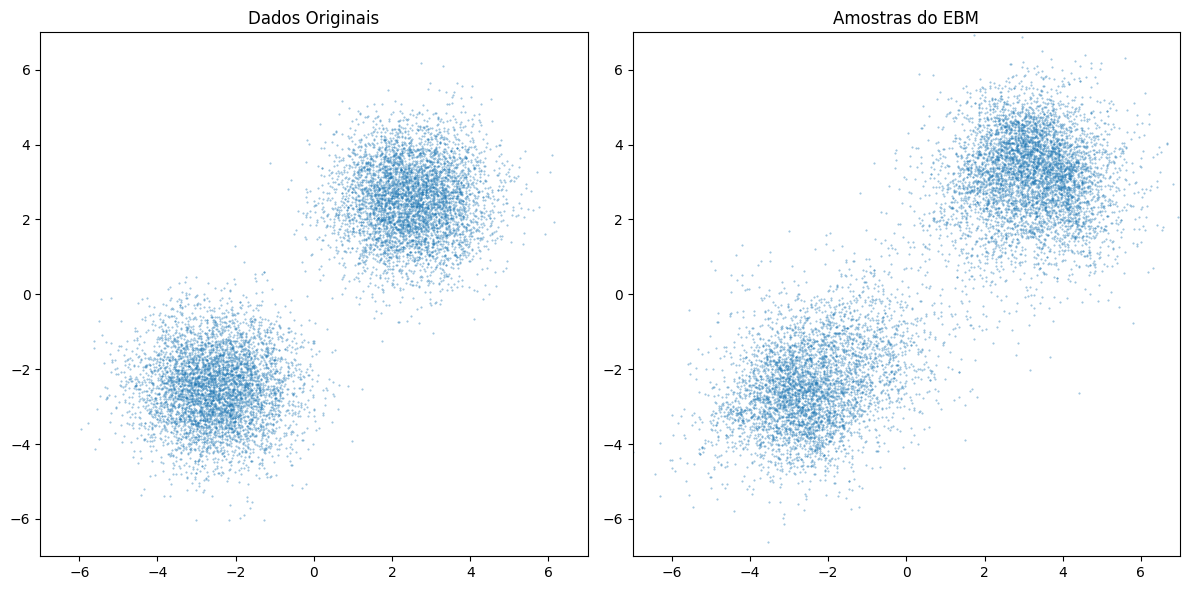

In [13]:
# Amostrando do EBM treinado
E.eval()
samples_persistent = x.detach().cpu().numpy()

# Comparar com o scatterplot original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data.cpu().numpy()[:,0], data.cpu().numpy()[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title('Dados Originais')

plt.subplot(1, 2, 2)
plt.scatter(samples_persistent[:,0], samples_persistent[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title(f'Amostras do EBM')

plt.tight_layout()
plt.show()

# Max_iter = 10

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

h = 10
d = 2
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
data = data.to('cuda')

max_iter = 10


x = torch.randn((N,2), device='cuda')*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.01)
sampler = torch_sgld.SGLD([x], lr=0.01)

chain_length=10

for i in range(max_iter):
    for i in range(chain_length):
        sampler.zero_grad()
        potential = E(x)
        potential.sum().backward()
        sampler.step()
    optimizer.zero_grad()
    loss = E(data).mean() - E(x.detach()).mean()
    loss.backward()
    optimizer.step()


Usando dispositivo: cuda


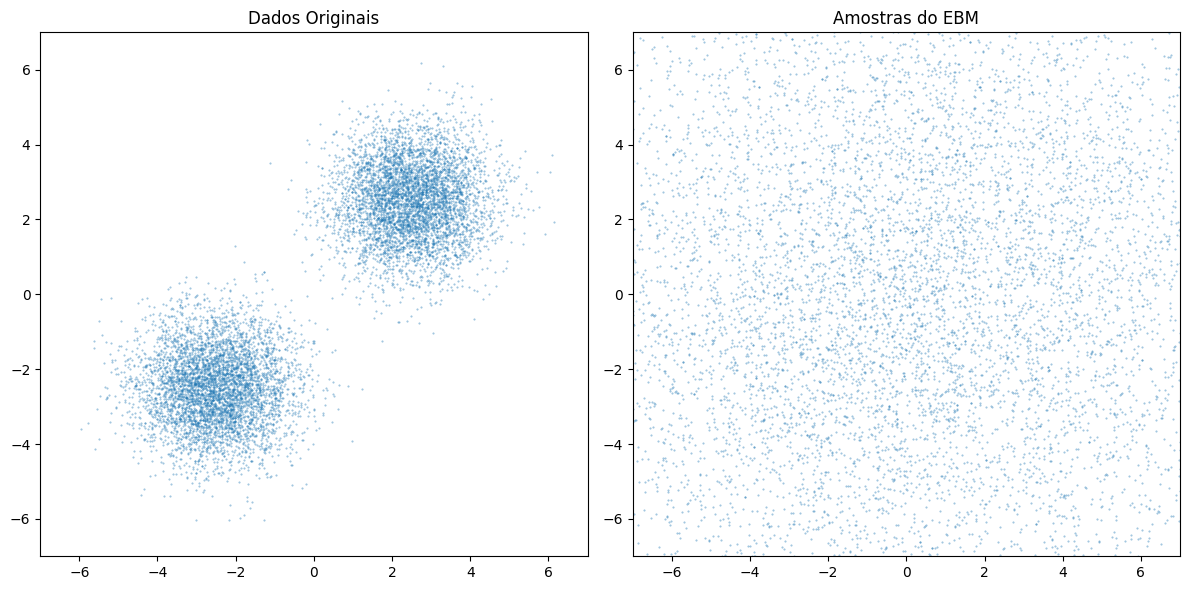

In [11]:
# Amostrando do EBM treinado
E.eval()
samples_persistent = x.detach().cpu().numpy()

# Comparar com o scatterplot original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data.cpu().numpy()[:,0], data.cpu().numpy()[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title('Dados Originais')

plt.subplot(1, 2, 2)
plt.scatter(samples_persistent[:,0], samples_persistent[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title(f'Amostras do EBM')

plt.tight_layout()
plt.show()

# Chain = 2

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

h = 10
d = 2
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
data = data.to('cuda')

max_iter = 1000


x = torch.randn((N,2), device='cuda')*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.01)
sampler = torch_sgld.SGLD([x], lr=0.01)

chain_length=2

for i in range(max_iter):
    for i in range(chain_length):
        sampler.zero_grad()
        potential = E(x)
        potential.sum().backward()
        sampler.step()
    optimizer.zero_grad()
    loss = E(data).mean() - E(x.detach()).mean()
    loss.backward()
    optimizer.step()


Usando dispositivo: cuda


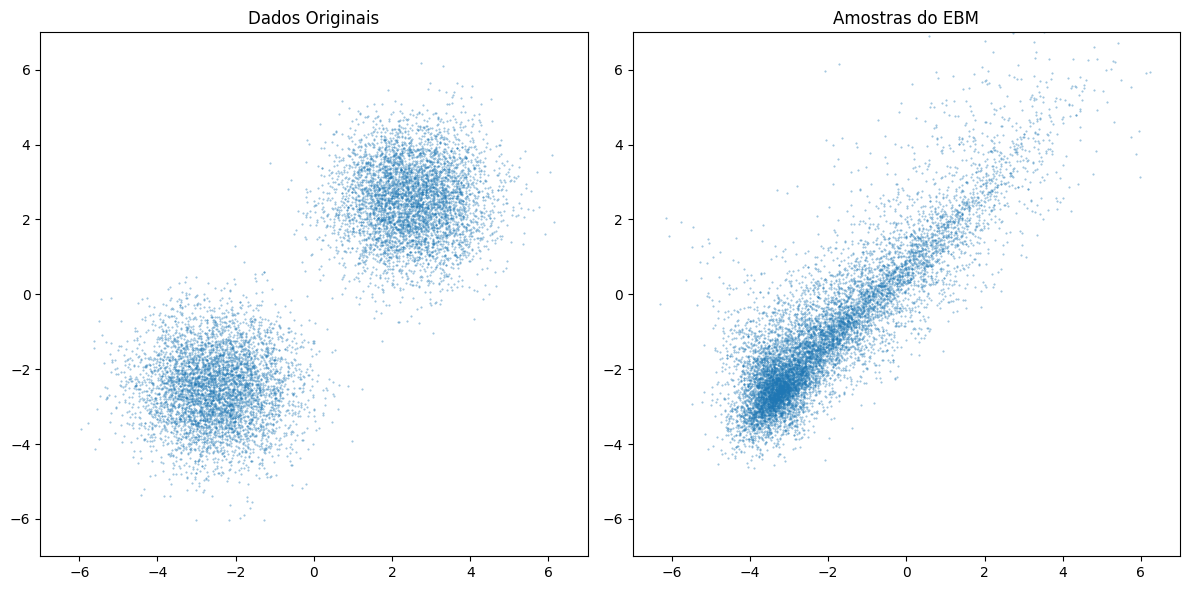

In [15]:
# Amostrando do EBM treinado
E.eval()
samples_persistent = x.detach().cpu().numpy()

# Comparar com o scatterplot original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data.cpu().numpy()[:,0], data.cpu().numpy()[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title('Dados Originais')

plt.subplot(1, 2, 2)
plt.scatter(samples_persistent[:,0], samples_persistent[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title(f'Amostras do EBM')

plt.tight_layout()
plt.show()

# Chain = 5

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

h = 10
d = 2
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
data = data.to('cuda')

max_iter = 1000


x = torch.randn((N,2), device='cuda')*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.01)
sampler = torch_sgld.SGLD([x], lr=0.01)

chain_length=5

for i in range(max_iter):
    for i in range(chain_length):
        sampler.zero_grad()
        potential = E(x)
        potential.sum().backward()
        sampler.step()
    optimizer.zero_grad()
    loss = E(data).mean() - E(x.detach()).mean()
    loss.backward()
    optimizer.step()


Usando dispositivo: cuda


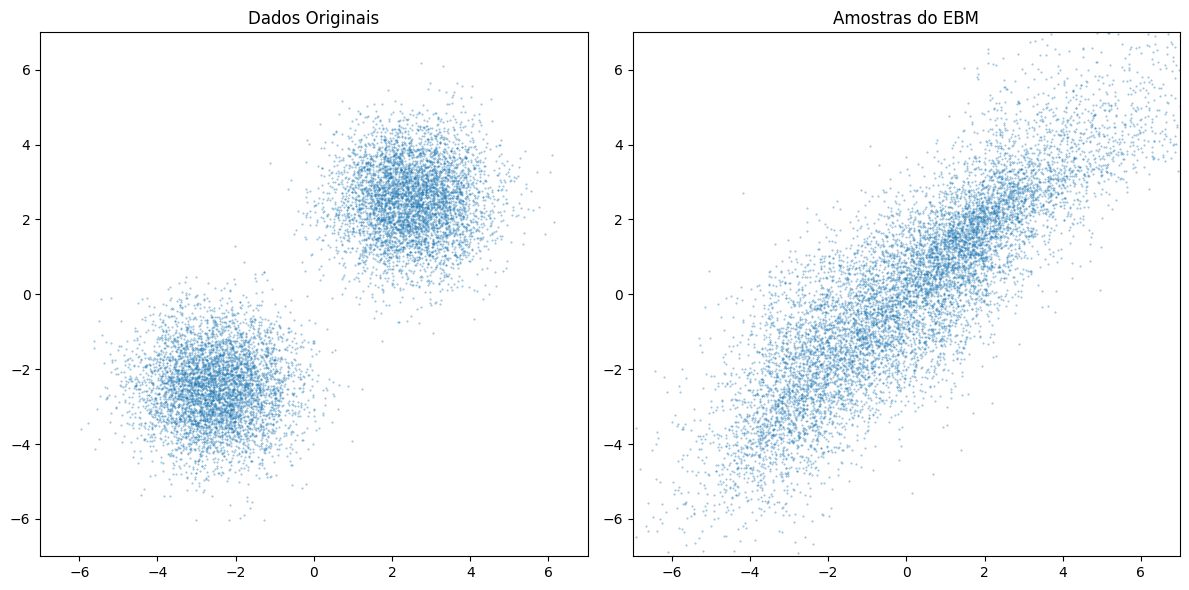

In [17]:
# Amostrando do EBM treinado
E.eval()
samples_persistent = x.detach().cpu().numpy()

# Comparar com o scatterplot original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data.cpu().numpy()[:,0], data.cpu().numpy()[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title('Dados Originais')

plt.subplot(1, 2, 2)
plt.scatter(samples_persistent[:,0], samples_persistent[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title(f'Amostras do EBM')

plt.tight_layout()
plt.show()

# Chain = 20

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

h = 10
d = 2
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
data = data.to('cuda')

max_iter = 1000


x = torch.randn((N,2), device='cuda')*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.01)
sampler = torch_sgld.SGLD([x], lr=0.01)

chain_length=5

for i in range(max_iter):
    for i in range(chain_length):
        sampler.zero_grad()
        potential = E(x)
        potential.sum().backward()
        sampler.step()
    optimizer.zero_grad()
    loss = E(data).mean() - E(x.detach()).mean()
    loss.backward()
    optimizer.step()


Usando dispositivo: cuda


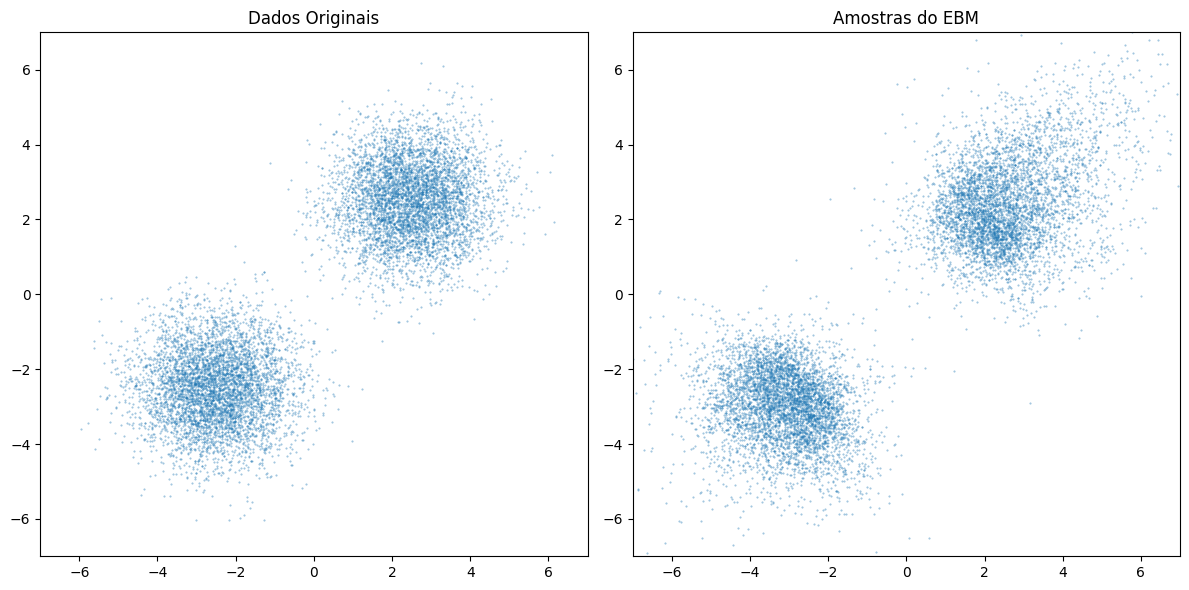

In [19]:
# Amostrando do EBM treinado
E.eval()
samples_persistent = x.detach().cpu().numpy()

# Comparar com o scatterplot original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data.cpu().numpy()[:,0], data.cpu().numpy()[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title('Dados Originais')

plt.subplot(1, 2, 2)
plt.scatter(samples_persistent[:,0], samples_persistent[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title(f'Amostras do EBM')

plt.tight_layout()
plt.show()

# Epoca começando em pontos dos dados


Treinando com inicialização da cadeia nos pontos de dados a cada época


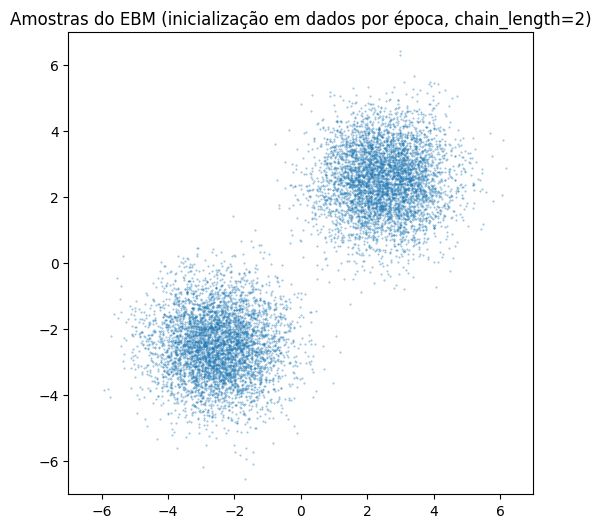

In [20]:
E_data_init = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
optimizer_data_init = torch.optim.Adam(E_data_init.parameters(), lr=0.01)
chain_length_data = 2

print("\nTreinando com inicialização da cadeia nos pontos de dados a cada época")
for i in range(max_iter):
    # Inicializa x sampling data points
    data_permuted = data[torch.randperm(data.size(0))]
    x_data = data_permuted[:N].clone().detach()
    x_data.requires_grad=True
    sampler_data = torch_sgld.SGLD([x_data], lr=0.01)

    for j in range(chain_length_data):
        sampler_data.zero_grad()
        potential_data = E_data_init(x_data)
        potential_data.sum().backward()
        sampler_data.step()

    optimizer_data_init.zero_grad()
    loss_data = E_data_init(data).mean() - E_data_init(x_data.detach()).mean()
    loss_data.backward()
    optimizer_data_init.step()

samples_data_init = x_data.detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(samples_data_init[:,0], samples_data_init[:,1], s=0.2, alpha=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title(f'Amostras do EBM (inicialização em dados por época, chain_length={chain_length_data})')
plt.show()

# Comentários

Inicializar a cadeia aleatoriamente fará a amostra ser fresca a cada época, o pode ajudar a prevenir que a cadeia SGLD fique presa em modos ou regiões de baixa probabilidade da distribuição de equilíbrio. Isso pode levar a uma melhor a distribuição geral. Contudo, isso provavlemente exigirá maior chain para conseguir convergir dentro de cada epoca, uma vez que o trabalho reinicia do zero toda vez.

Sobre a inicialização nos dados, inicializar a cadeia nos pontos de dados observados iniciará em pontos que provavelmente estão em regiões de alta probabilidade da distribuição alvo. Isso pode acelerar a convergência da cadeia
SGLD para a distribuição de equilíbrio dentro de cada época, exigindo um `chain_length` menor em comparação com a inicialização aleatória. O que pode ser observado claramente na implementação acima.

Usando `chain_length` = 2, o modelo original não cosnegui convergir, contudo, o modelo com inicialização nos dados conseguiu.

**2.** Treine um EBM via máxima verossimlhança usando o MNIST. Mostre as amostras geradas pelo modelo. Crie um conjunto de amostras do EBM e mostre o histograma de suas respectivas energias. Mostre e comente alguns exemplos de amostras de alta e de baixa energia.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

batch_size = 128
epochs = 10
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = mnist_trainset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Usando o dispositivo: cuda


In [29]:
class EnergyModel(nn.Module):
    """
    Uma rede neural simples para atuar como nossa função de energia.
    Entrada: imagem (batch, 1, 28, 28)
    Saída: energia (batch, 1)
    """
    def __init__(self):
        super(EnergyModel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.main(x)

#  modelo e o otimizador
model = EnergyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
def generate_samples(model, num_samples=batch_size, img_shape=(1, 28, 28), steps=60, step_size=10, noise_scale=0.005):
    """
    Gera amostras a partir do modelo usando Dinâmica de Langevin.
    """
    # Inicia com ruído aleatório
    samples = torch.rand(num_samples, *img_shape).to(device)
    samples.requires_grad = True

    for _ in range(steps):
        # Calcula a energia e o gradiente da energia em relação às amostras
        energy = model(samples)
        energy.sum().backward()

        samples.data = samples.data - step_size * samples.grad.data + noise_scale * torch.randn_like(samples)

        samples.data = torch.clamp(samples.data, -1.0, 1.0)

        samples.grad.zero_()

    return samples.detach()

# --- Loop de Treinamento ---
print("Iniciando o treinamento...")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)

        energy_real = model(real_images)
        loss_real = energy_real.mean()

        fake_samples = generate_samples(model, num_samples=real_images.size(0))
        energy_fake = model(fake_samples)
        loss_fake = energy_fake.mean()

        optimizer.zero_grad()
        loss = loss_real - loss_fake
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Energia Real: {loss_real.item():.4f}, Energia Falsa: {loss_fake.item():.4f}")

print("Treinamento concluído!")

Iniciando o treinamento...
Epoch [1/10], Step [100/469], Loss: -0.0174, Energia Real: -8.5591, Energia Falsa: -8.5417
Epoch [1/10], Step [200/469], Loss: -0.2727, Energia Real: -14.0922, Energia Falsa: -13.8196
Epoch [1/10], Step [300/469], Loss: -0.2996, Energia Real: -18.8470, Energia Falsa: -18.5475
Epoch [1/10], Step [400/469], Loss: 0.4860, Energia Real: -23.2745, Energia Falsa: -23.7605
Epoch [2/10], Step [100/469], Loss: 0.1903, Energia Real: -26.6032, Energia Falsa: -26.7934
Epoch [2/10], Step [200/469], Loss: 0.9186, Energia Real: -27.7112, Energia Falsa: -28.6298
Epoch [2/10], Step [300/469], Loss: -0.0192, Energia Real: -29.6569, Energia Falsa: -29.6376
Epoch [2/10], Step [400/469], Loss: -0.7263, Energia Real: -30.4045, Energia Falsa: -29.6781
Epoch [3/10], Step [100/469], Loss: -0.1761, Energia Real: -28.2331, Energia Falsa: -28.0570
Epoch [3/10], Step [200/469], Loss: -0.4265, Energia Real: -29.8948, Energia Falsa: -29.4683
Epoch [3/10], Step [300/469], Loss: 0.8928, Ener

Gerando amostras finais...


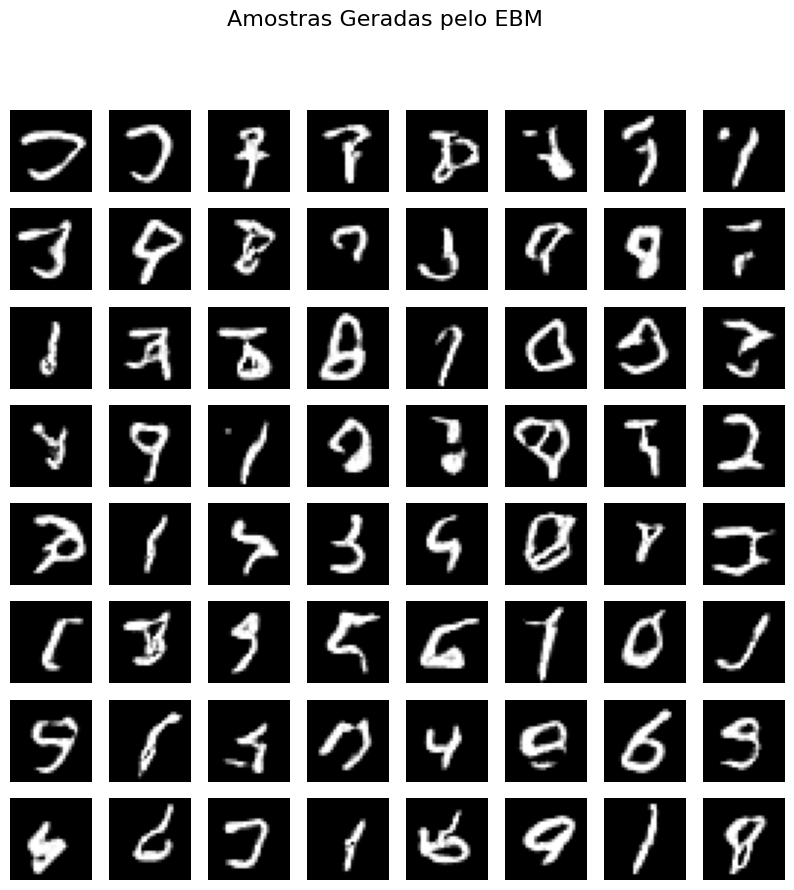

In [31]:
# Gerar amostras com o modelo treinado
print("Gerando amostras finais...")
generated_samples = generate_samples(model, num_samples=64)

# Plotar as amostras geradas
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = generated_samples[i].cpu().detach().numpy().squeeze()
    img = (img + 1) / 2
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle("Amostras Geradas pelo EBM", fontsize=16)
plt.show()

Calculando energias para o histograma...


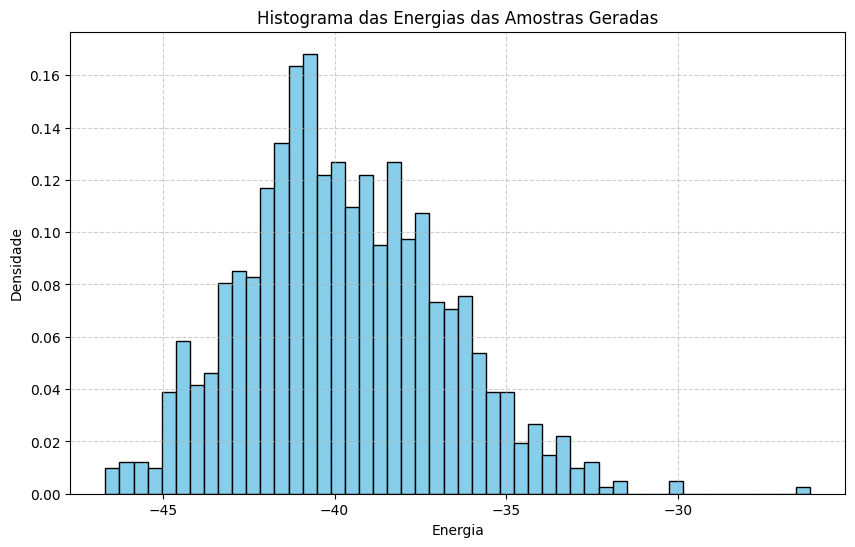

In [32]:
# Gerar um conjunto maior de amostras para análise de energia
print("Calculando energias para o histograma...")
samples_for_hist = generate_samples(model, num_samples=1000)
energies = model(samples_for_hist).cpu().detach().numpy().flatten()

# Plotar o histograma das energias
plt.figure(figsize=(10, 6))
plt.hist(energies, bins=50, density=True, color='skyblue', edgecolor='black')
plt.title("Histograma das Energias das Amostras Geradas")
plt.xlabel("Energia")
plt.ylabel("Densidade")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

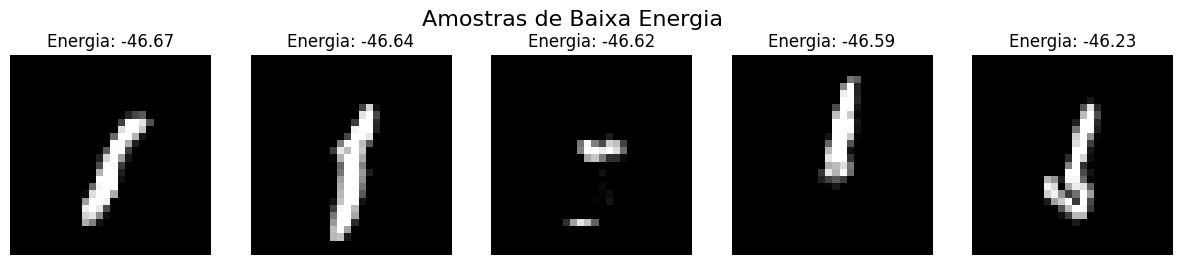

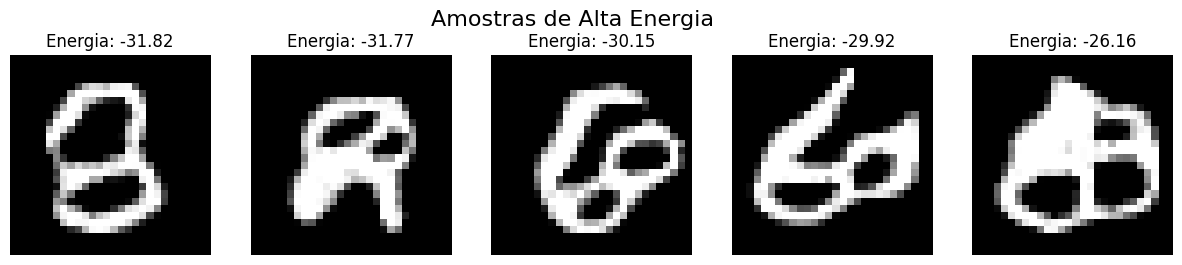

In [33]:
sorted_indices = np.argsort(energies)
low_energy_samples = samples_for_hist[sorted_indices[:5]]
high_energy_samples = samples_for_hist[sorted_indices[-5:]]

low_energies = energies[sorted_indices[:5]]
high_energies = energies[sorted_indices[-5:]]

# Função para plotar as amostras com suas energias
def plot_samples_with_energy(samples, energies, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes.flatten()):
        img = samples[i].cpu().detach().numpy().squeeze()
        img = (img + 1) / 2
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Energia: {energies[i]:.2f}")
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

# Plotar amostras de baixa energia
plot_samples_with_energy(low_energy_samples, low_energies, "Amostras de Baixa Energia")

# Plotar amostras de alta energia
plot_samples_with_energy(high_energy_samples, high_energies, "Amostras de Alta Energia")

# Comentário

Amostras de Baixa Energia são as amostras que o modelo considera as "melhores" ou mais "confiáveis". Elas devem se parecer com dígitos bem formados. O modelo atribui a elas uma energia baixa porque elas se encaixam perfeitamente na distribuição de dados que ele aprendeu do MNIST.

Amostras de Alta Energia são as amostras que o modelo considera "ruins" ou menos prováveis. Elas geralmente serão meio deformadas. Elas não se encaixam bem no padrão dos dígitos do MNIST e, portanto, são penalizadas com alta energia.

No meu caso, por mais que os de baixa energia efetivamente se pareçam com o número 1. Parece que, no geral, o modelo não funcionou muito muito bem.